## Read an XES file and Discover a BPMN process

In [141]:
import pandas as pd
import pm4py
import random
import warnings 
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.util import dataframe_utils
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
from scipy import stats
import networkx as nx

### Convert XES to CSV file

### taking only 10% of the data set since its size is too large for our computers to analyze

In [14]:
df_original = pd.read_csv('./BPIChallenge2017.csv')
df_original = df_original.drop(columns=['Unnamed: 0', 'lifecycle:transition', 'case:ApplicationType', 'OfferID', 'FirstWithdrawalAmount'])

df_original['EventOrigin'] = df_original['EventOrigin'].replace({'Application': 'A', 'Workflow': 'W', 'Offer': 'O'})

df_original['time:timestamp'] = pd.to_datetime(df_original['time:timestamp'], errors='coerce')

df_original = df_original[df_original['concept:name'] != df_original['concept:name'].shift()]

df_original['offersDeclined'] = df_original[df_original['concept:name'] == 'O_Create Offer'].groupby('case:concept:name').cumcount()

offer_attributes_df = df_original[df_original['concept:name'] == 'O_Create Offer'].copy()
offer_attributes_df.set_index('case:concept:name', inplace=True)
offer_attributes_df = offer_attributes_df[['OfferedAmount', 'CreditScore', 'case:RequestedAmount', 'NumberOfTerms', 'Accepted', 'MonthlyCost', 'Selected', 'case:LoanGoal','time:timestamp', 'offersDeclined']]

df_original = df_original.drop(columns=['OfferedAmount', 'CreditScore', 'case:RequestedAmount', 'NumberOfTerms', 'Accepted', 'MonthlyCost', 'Selected'])


offer_attributes_df['offersDeclined'] = offer_attributes_df['offersDeclined'].fillna(0)

offer_attributes_df['requestedOfferedRatio'] = offer_attributes_df['OfferedAmount'] / offer_attributes_df['case:RequestedAmount']

offer_attributes_df.reset_index(inplace=True)

# df_original.to_csv('BPI2017.csv', index=False)
# offer_attributes_df.to_csv('BPIattributes.csv', index=False)

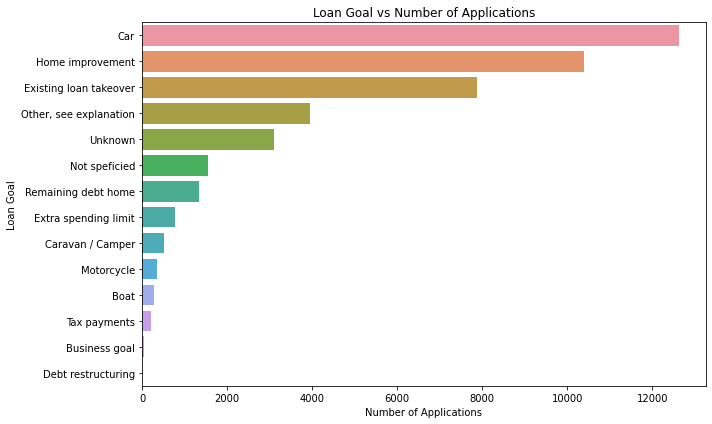

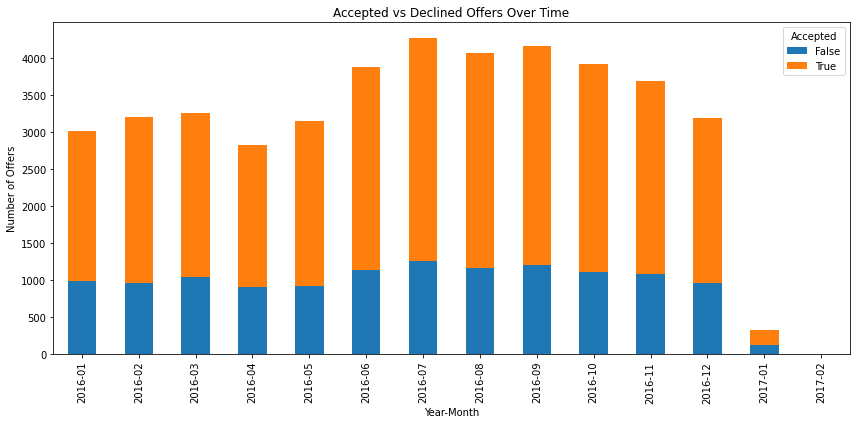

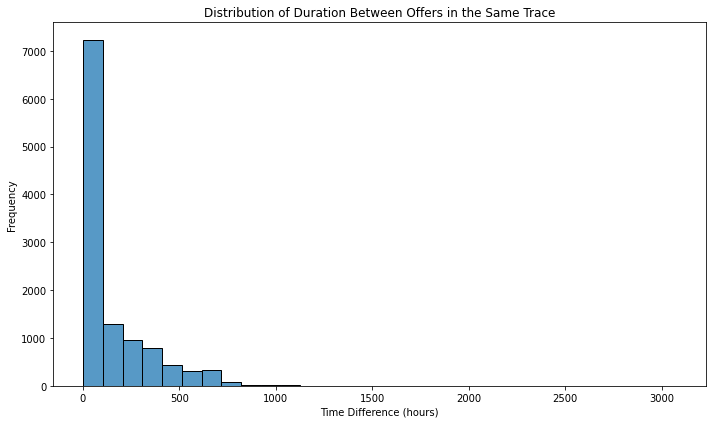

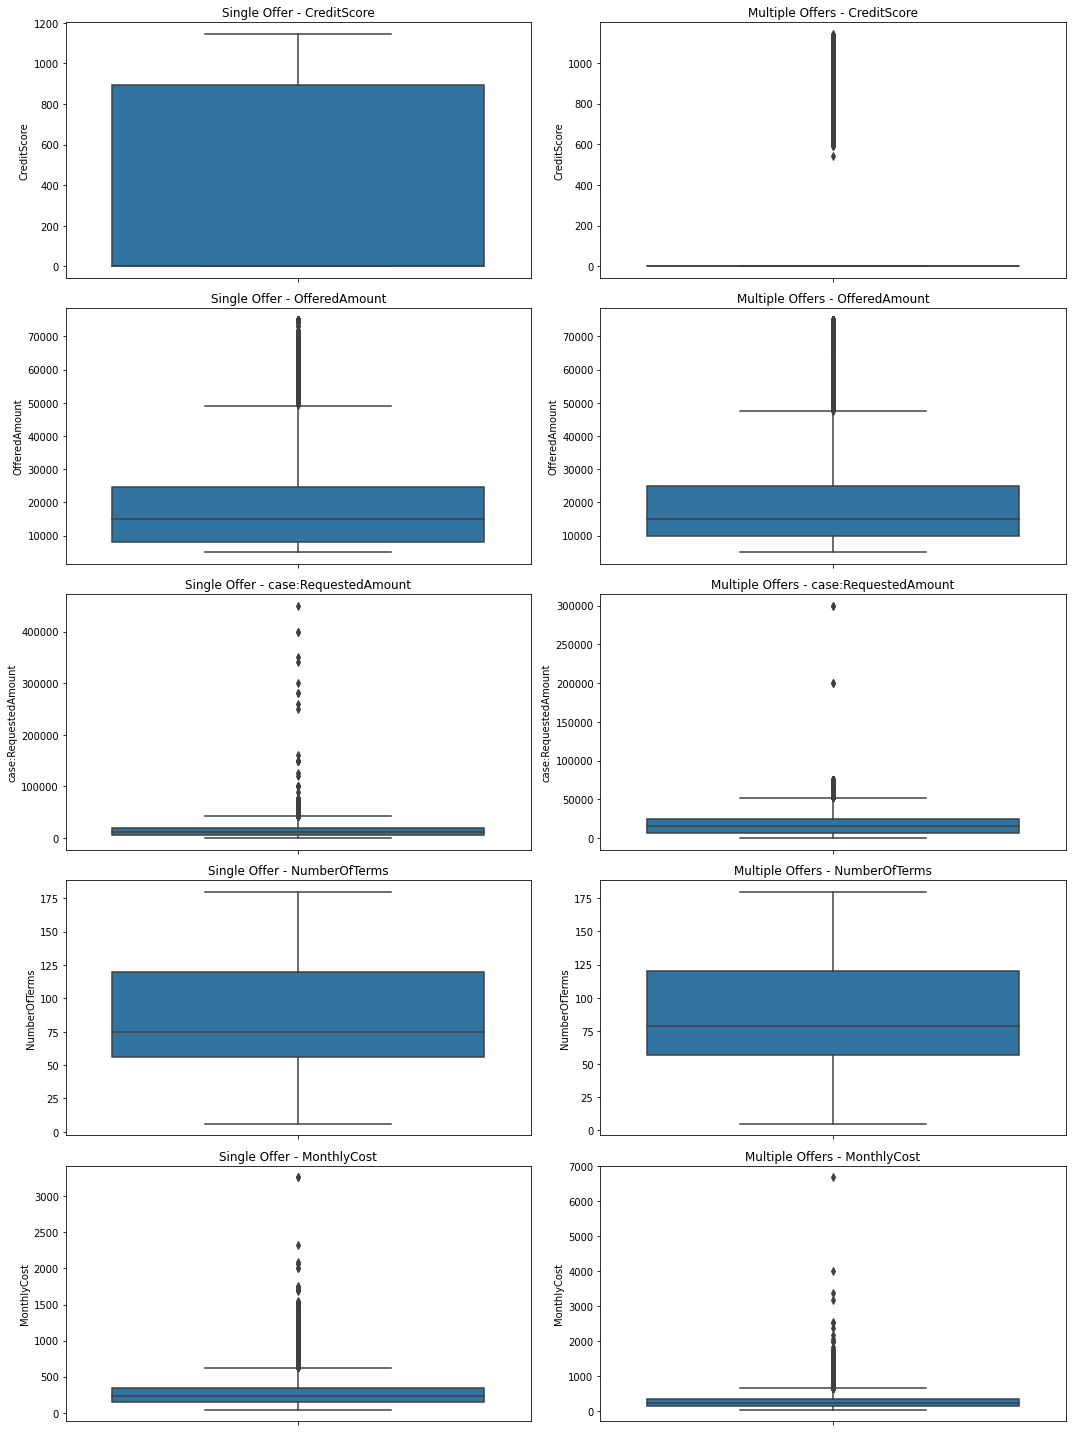

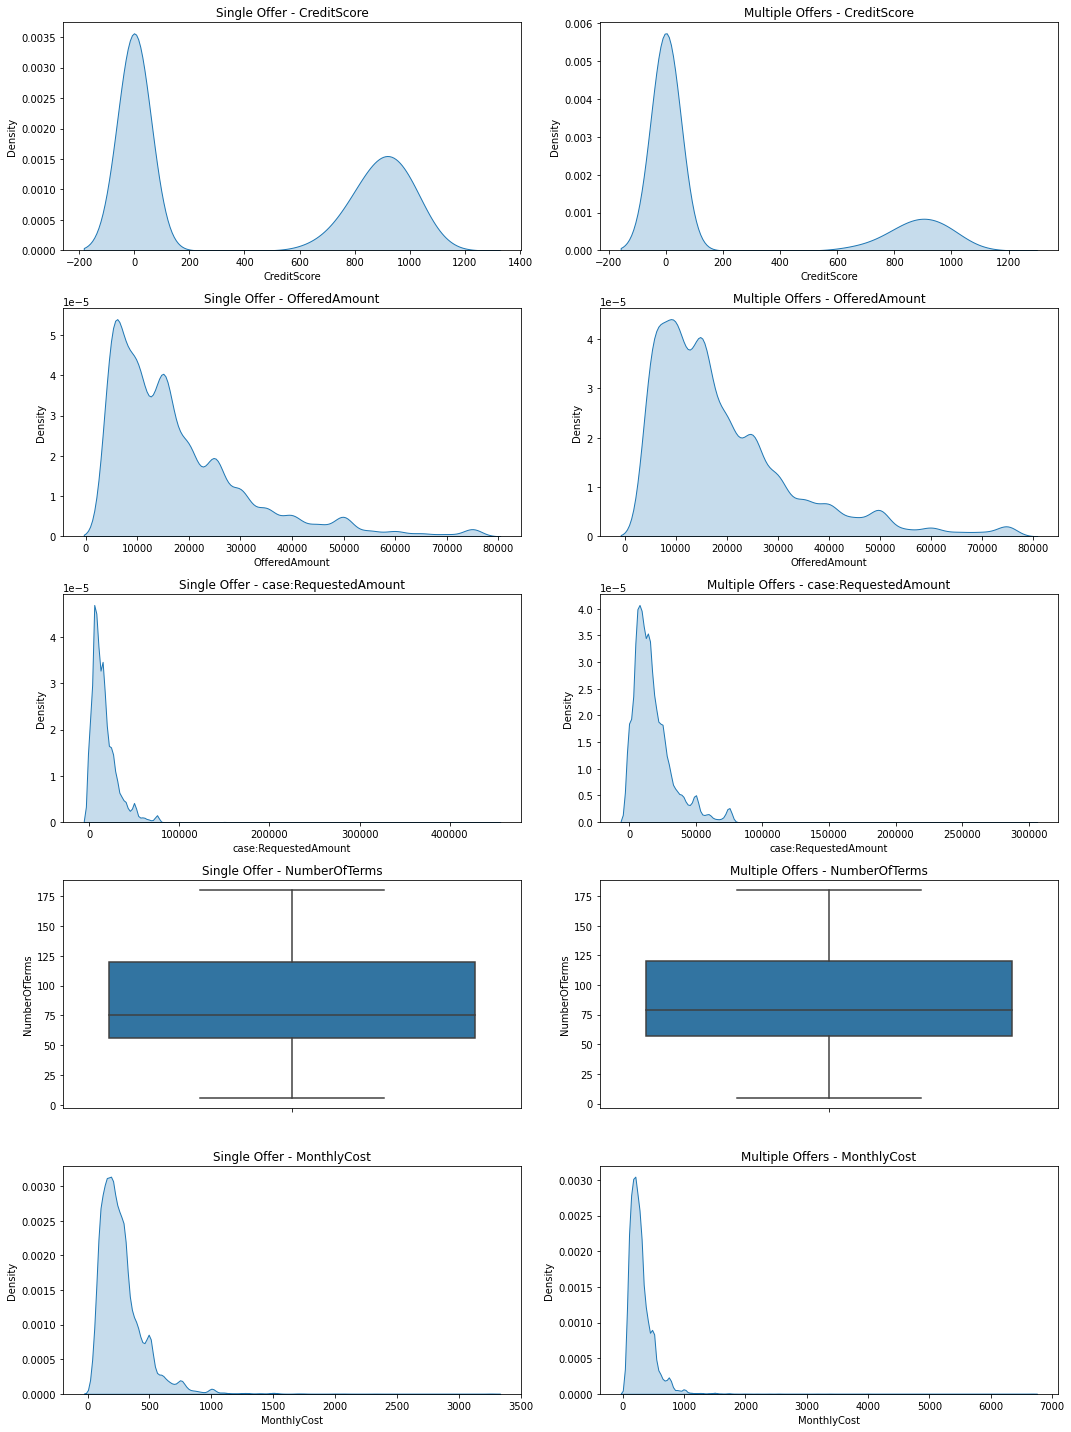

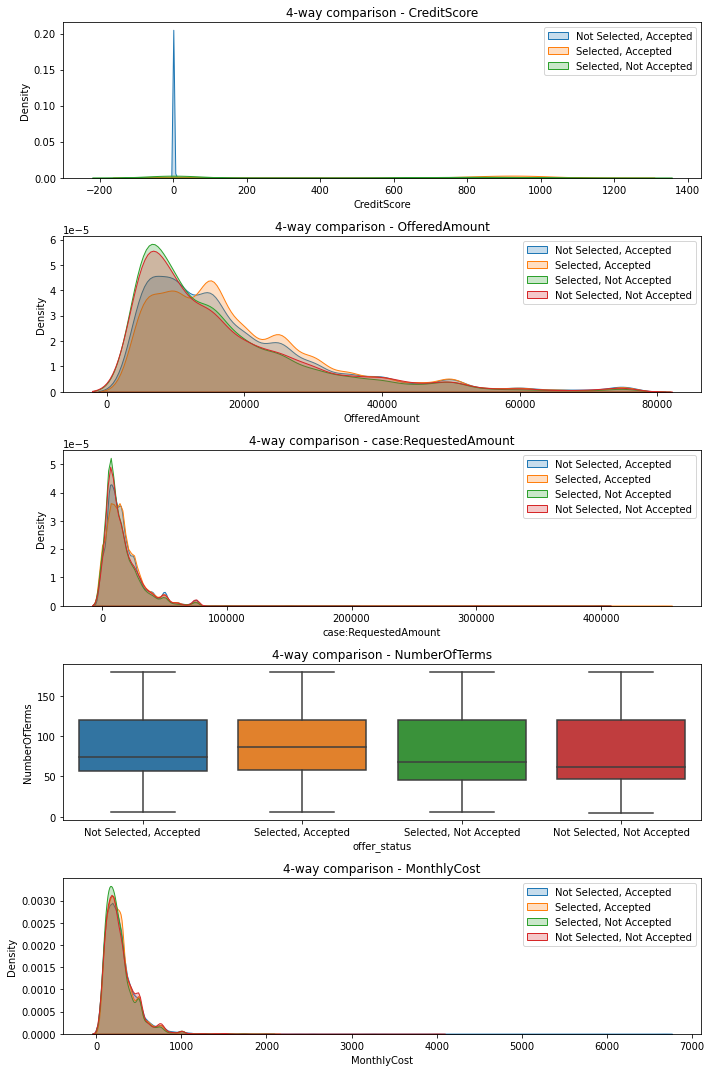

In [15]:
df = offer_attributes_df
df['time:timestamp'] = pd.to_datetime(df['time:timestamp'])

# Sort data by timestamp
df = df.sort_values('time:timestamp')

# Visualization 1: Loan Goal vs Number of Applications
plt.figure(figsize=(10, 6))
sns.countplot(y='case:LoanGoal', data=df, order = df['case:LoanGoal'].value_counts().index)
plt.title('Loan Goal vs Number of Applications')
plt.xlabel('Number of Applications')
plt.ylabel('Loan Goal')
plt.tight_layout()
plt.show()

# Visualization 2: Accepted vs Declined Offers over time
df['year-month'] = df['time:timestamp'].dt.to_period('M')
accepted_declined_over_time = df.groupby(['year-month', 'Accepted']).size().unstack(fill_value=0)

ax = accepted_declined_over_time.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Accepted vs Declined Offers Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Number of Offers')
plt.tight_layout()
plt.show()

df = df.sort_values(['case:concept:name', 'time:timestamp'])
df['time_diff'] = df.groupby('case:concept:name')['time:timestamp'].diff().dt.total_seconds() / 3600  # in hours

# Plot the distribution of time difference
plt.figure(figsize=(10, 6))
sns.histplot(df['time_diff'].dropna(), kde=False, bins=30)
plt.title('Distribution of Duration Between Offers in the Same Trace')
plt.xlabel('Time Difference (hours)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Visualization 5: Comparison of applications that had only 1 offer and applications that had more than one offer
df['offer_counts'] = df.groupby('case:concept:name')['case:concept:name'].transform('count')
single_offer_df = df[df['offer_counts'] == 1]
multi_offer_df = df[df['offer_counts'] > 1]

features = ['CreditScore', 'OfferedAmount', 'case:RequestedAmount', 'NumberOfTerms', 'MonthlyCost']
fig, axs = plt.subplots(len(features), 2, figsize=(15, 20))
for i, feature in enumerate(features):
    sns.boxplot(ax=axs[i, 0], y=single_offer_df[feature])
    axs[i, 0].set_title(f'Single Offer - {feature}')
    sns.boxplot(ax=axs[i, 1], y=multi_offer_df[feature])
    axs[i, 1].set_title(f'Multiple Offers - {feature}')
plt.tight_layout()
plt.show()

# Visualization 6: 4-way comparison of each offer
df['offer_status'] = df.apply(lambda row: 'Selected, Accepted' if row['Selected'] and row['Accepted'] else 
                              ('Not Selected, Accepted' if not row['Selected'] and row['Accepted'] else 
                               ('Selected, Not Accepted' if row['Selected'] and not row['Accepted'] else 
                                'Not Selected, Not Accepted')), axis=1)

# Visualization 5: Using Kernel Density Plots instead of Violin plots for a better view of the distributions
fig, axs = plt.subplots(len(features), 2, figsize=(15, 20))
for i, feature in enumerate(features):
    if feature != 'NumberOfTerms':
        sns.kdeplot(ax=axs[i, 0], data=single_offer_df[feature], shade=True)
        axs[i, 0].set_title(f'Single Offer - {feature}')
        sns.kdeplot(ax=axs[i, 1], data=multi_offer_df[feature], shade=True)
        axs[i, 1].set_title(f'Multiple Offers - {feature}')
    else:
        sns.boxplot(ax=axs[i, 0], y=single_offer_df[feature])
        axs[i, 0].set_title(f'Single Offer - {feature}')
        sns.boxplot(ax=axs[i, 1], y=multi_offer_df[feature])
        axs[i, 1].set_title(f'Multiple Offers - {feature}')
plt.tight_layout()
plt.show()

# Visualization 6: Using Kernel Density Plots instead of Violin plots for a better view of the distributions
fig, axs = plt.subplots(len(features), 1, figsize=(10, 15))
for i, feature in enumerate(features):
    if feature != 'NumberOfTerms':
        for category in df['offer_status'].unique():
            sns.kdeplot(ax=axs[i], data=df[df['offer_status'] == category][feature], label=category, shade=True)
        axs[i].set_title(f'4-way comparison - {feature}')
        axs[i].legend()
    else:
        sns.boxplot(ax=axs[i], x=df['offer_status'], y=df[feature])
        axs[i].set_title(f'4-way comparison - {feature}')
plt.tight_layout()
plt.show()

In [80]:
print(len(filtered_trace_df))
print(len(trace_df))

print(len(df))

28381
31509
754062


### Read a CSV file and Discover a BPMN process

In [193]:
data = pd.read_csv('./data/BPIChallenge2017_reduced.csv') 
data['time:timestamp'] = pd.to_datetime(data['time:timestamp'],format='mixed')
data.head()


Action org:resource            concept:name  EventOrigin   
0      Created       User_1    A_Create Application  Application  \
1  statechange       User_1             A_Submitted  Application   
2      Created       User_1          W_Handle leads     Workflow   
3      Deleted       User_1          W_Handle leads     Workflow   
4      Created       User_1  W_Complete application     Workflow   

                 EventID lifecycle:transition   
0  Application_652823628             complete  \
1   ApplState_1582051990             complete   
2    Workitem_1298499574             schedule   
3    Workitem_1673366067             withdraw   
4    Workitem_1493664571             schedule   

                    time:timestamp           case:LoanGoal   
0 2016-01-01 09:51:15.304000+00:00  Existing loan takeover  \
1 2016-01-01 09:51:15.352000+00:00  Existing loan takeover   
2 2016-01-01 09:51:15.774000+00:00  Existing loan takeover   
3 2016-01-01 09:52:36.392000+00:00  Existing loan takeover   
4 2016-01-01 09:52:36.403000+00:00  Existing loan takeover   

  case:ApplicationType      case:concept:name  case:RequestedAmount   
0           New credit  Application_652823628                 20000  \
1           New credit  Application_652823628                 20000   
2           New credit  Application_652823628                 20000   
3           New credit  Application_652823628                 20000   
4           New credit  Application_652823628                 20000   

   FirstWithdrawalAmount  NumberOfTerms Accepted  MonthlyCost Selected   
0                    NaN            NaN      NaN          NaN      NaN  \
1                    NaN            NaN      NaN          NaN      NaN   
2                    NaN            NaN      NaN          NaN      NaN   
3                    NaN            NaN      NaN          NaN      NaN   
4                    NaN            NaN      NaN          NaN      NaN   

   CreditScore  OfferedAmount OfferID  
0          NaN            NaN     NaN  
1          NaN            NaN     NaN  
2          NaN            NaN     NaN  
3          NaN            NaN     NaN  
4          NaN            NaN     NaN

In [194]:
data.describe(include='all')


Action org:resource            concept:name EventOrigin   
count        123727       123727                  123727      123727  \
unique            5           86                      25           3   
top     statechange       User_1  W_Validate application    Workflow   
freq          36578        14326                   24251       79371   
mean            NaN          NaN                     NaN         NaN   
min             NaN          NaN                     NaN         NaN   
25%             NaN          NaN                     NaN         NaN   
50%             NaN          NaN                     NaN         NaN   
75%             NaN          NaN                     NaN         NaN   
max             NaN          NaN                     NaN         NaN   
std             NaN          NaN                     NaN         NaN   

                      EventID lifecycle:transition   
count                  123727               123727  \
unique                 123727                    7   
top     Application_652823628             complete   
freq                        1                48936   
mean                      NaN                  NaN   
min                       NaN                  NaN   
25%                       NaN                  NaN   
50%                       NaN                  NaN   
75%                       NaN                  NaN   
max                       NaN                  NaN   
std                       NaN                  NaN   

                             time:timestamp case:LoanGoal   
count                                123727        123727  \
unique                                  NaN            13   
top                                     NaN           Car   
freq                                    NaN         39313   
mean    2016-01-31 19:27:06.835764992+00:00           NaN   
min        2016-01-01 09:51:15.304000+00:00           NaN   
25%     2016-01-19 10:54:20.485499904+00:00           NaN   
50%     2016-02-01 08:14:47.324999936+00:00           NaN   
75%        2016-02-10 15:06:25.160000+00:00           NaN   
max        2016-11-15 12:11:57.290000+00:00           NaN   
std                                     NaN           NaN   

       case:ApplicationType       case:concept:name  case:RequestedAmount   
count                123727                  123727         123727.000000  \
unique                    2                    3150                   NaN   
top              New credit  Application_2037628374                   NaN   
freq                 108858                     180                   NaN   
mean                    NaN                     NaN          15575.005165   
min                     NaN                     NaN              0.000000   
25%                     NaN                     NaN           6000.000000   
50%                     NaN                     NaN          13000.000000   
75%                     NaN                     NaN          21500.000000   
max                     NaN                     NaN         400000.000000   
std                     NaN                     NaN          14722.806743   

        FirstWithdrawalAmount  NumberOfTerms Accepted  MonthlyCost Selected   
count             4628.000000    4628.000000     4628  4628.000000     4628  \
unique                    NaN            NaN        2          NaN        2   
top                       NaN            NaN     True          NaN    False   
freq                      NaN            NaN     3137          NaN     2444   
mean              6930.383349      81.363224      NaN   254.701670      NaN   
min                  0.000000       6.000000      NaN    50.000000      NaN   
25%                  0.000000      56.000000      NaN   150.000000      NaN   
50%               5000.000000      74.000000      NaN   220.000000      NaN   
75%              10000.000000     120.000000      NaN   305.042500      NaN   
max              50000.000000     138.000000      N

In [195]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123727 entries, 0 to 123726
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   Action                 123727 non-null  object             
 1   org:resource           123727 non-null  object             
 2   concept:name           123727 non-null  object             
 3   EventOrigin            123727 non-null  object             
 4   EventID                123727 non-null  object             
 5   lifecycle:transition   123727 non-null  object             
 6   time:timestamp         123727 non-null  datetime64[ns, UTC]
 7   case:LoanGoal          123727 non-null  object             
 8   case:ApplicationType   123727 non-null  object             
 9   case:concept:name      123727 non-null  object             
 10  case:RequestedAmount   123727 non-null  int64              
 11  FirstWithdrawalAmount  4628 non-null   

In [196]:
data.isnull().sum().sort_values(ascending=False)


OfferedAmount            119099
CreditScore              119099
Selected                 119099
MonthlyCost              119099
Accepted                 119099
NumberOfTerms            119099
FirstWithdrawalAmount    119099
OfferID                  107625
case:RequestedAmount          0
Action                        0
org:resource                  0
case:ApplicationType          0
case:LoanGoal                 0
time:timestamp                0
lifecycle:transition          0
EventID                       0
EventOrigin                   0
concept:name                  0
case:concept:name             0
dtype: int64

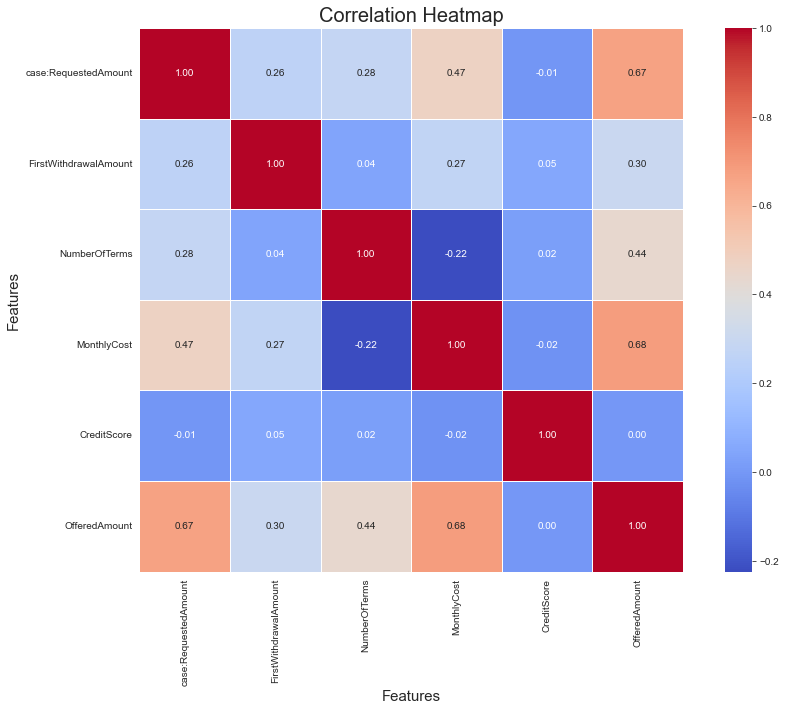

In [197]:
numeric_df = data.select_dtypes(include=['number'])
numeric_df
corr = numeric_df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True,  fmt=".2f",  cmap='coolwarm', cbar=True,  square=True,  linewidths=0.5)  
plt.title('Correlation Heatmap', fontsize=20)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Features', fontsize=15)

plt.show()

### what is the frequency of offers being accepted by the bank?

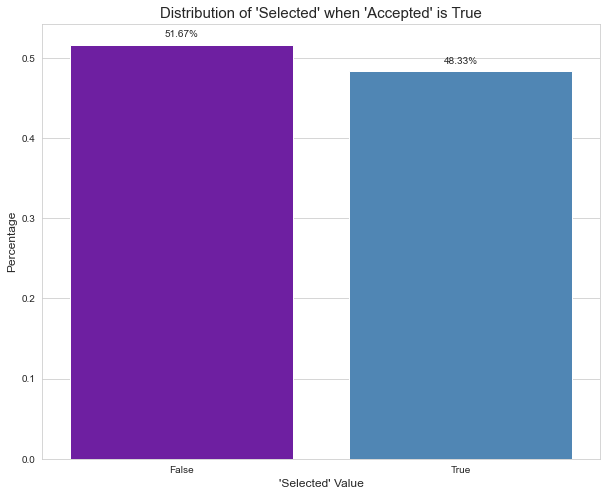

In [198]:
data['Accepted'] = data['Accepted'].astype('category')
data['Selected'] = data['Selected'].astype('category')
plt.figure(figsize=[10,8])
accepted_selected = data[data['Accepted'] == True]['Selected'].value_counts(normalize=True)
palette = ["#7209B7","#3F88C5","#136F63","#F72585","#FFBA08"]
ax = sns.barplot(x=accepted_selected.index, y=accepted_selected.values, palette=palette)
ax.set_title("Distribution of 'Selected' when 'Accepted' is True", fontsize=15)
ax.set_ylabel("Percentage", fontsize=12)
ax.set_xlabel("'Selected' Value", fontsize=12)

for i, v in enumerate(accepted_selected):
    ax.text(i, v + 0.01, '{:.2f}%'.format(v*100), horizontalalignment ='center', fontsize=10)

plt.show()


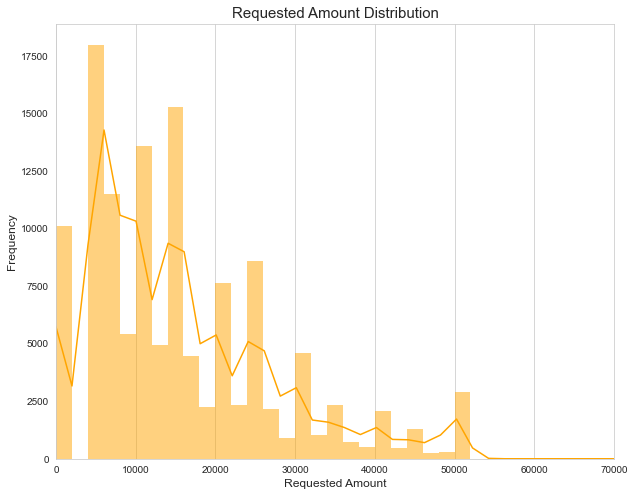

In [199]:
sns.set_style('whitegrid')
color = "orange"
plt.figure(figsize=[10,8])
sns.histplot(data['case:RequestedAmount'], bins=200, kde=True, color=color, linewidth=0)
plt.title("Requested Amount Distribution", fontsize=15)
plt.xlabel("Requested Amount", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y')
min_amount = np.min(data['case:RequestedAmount'])

plt.xlim(min_amount, 70000)  # Set x-axis limits
plt.show()

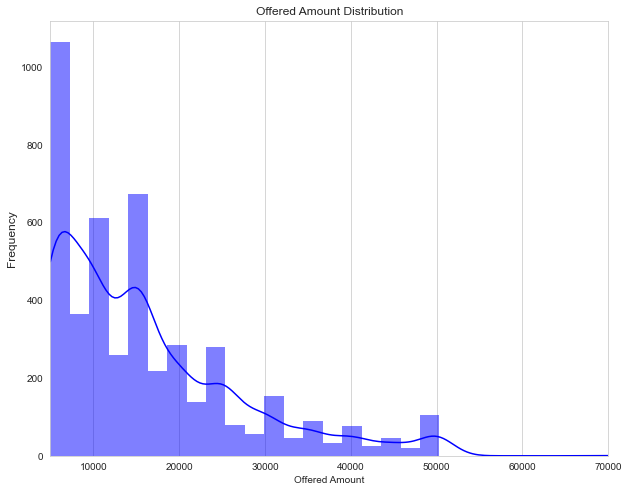

In [200]:
sns.set_style('whitegrid')
color = "blue"
plt.figure(figsize=[10,8])
sns.histplot(data['OfferedAmount'], bins=30, kde=True, color=color, linewidth=0)
plt.title("Offered Amount Distribution")
plt.xlabel("Offered Amount")
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y')
min_amount = np.min(data['OfferedAmount'])
plt.xlim(min_amount, 70000)  # Set x-axis limits
plt.show()

In [201]:
offer_data = data[data['concept:name'] == 'O_Create Offer']
columns_to_keep = ['case:RequestedAmount', 'OfferedAmount', 'case:concept:name','Selected','case:LoanGoal']  # Specify the columns you want to keep
offer_data = offer_data[columns_to_keep]
offer_data.rename(columns={'case:RequestedAmount': 'RequestedAmount', 'case:concept:name': 'CaseID','case:LoanGoal': "LoanGoal","Selected" : "Target"}, inplace=True)
offer_data = offer_data.drop_duplicates(subset='CaseID', keep='last')
outlier_threshold = 50000
offer_data = offer_data[offer_data['RequestedAmount'] <= outlier_threshold]
offer_data['ReqOfferRatio'] = offer_data['OfferedAmount'] / offer_data['RequestedAmount']



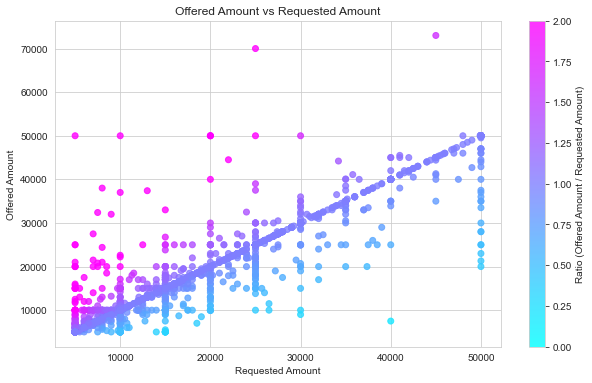

In [202]:

plt.figure(figsize=(10, 6))
plt.scatter(offer_data['RequestedAmount'], offer_data['OfferedAmount'], c=offer_data['ReqOfferRatio'], cmap='cool', alpha=0.8, vmin=0, vmax=2)
plt.title('Offered Amount vs Requested Amount')
plt.xlabel('Requested Amount')
plt.ylabel('Offered Amount')
plt.colorbar(label='Ratio (Offered Amount / Requested Amount)')
plt.show()


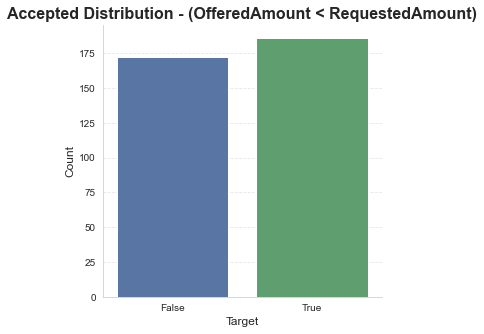

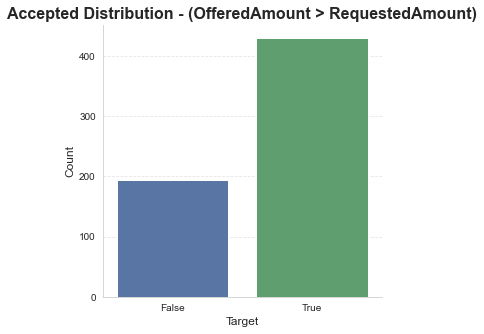

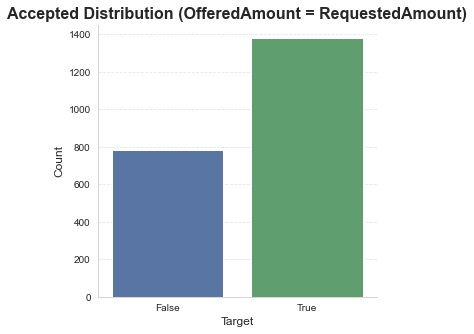

In [203]:
offer_data['Target'] = offer_data['Target'].astype('category')
offered_less = offer_data[offer_data['OfferedAmount'] < offer_data['RequestedAmount']]
offered_more = offer_data[offer_data['OfferedAmount'] > offer_data['RequestedAmount']]
offered_eq = offer_data[offer_data['OfferedAmount'] == offer_data['RequestedAmount']]

colors = ['#4c72b0', '#55a868']

# Plot for 'OfferedAmount < RequestedAmount'
plt.figure(figsize=[5, 5])
ax = sns.countplot(data=offered_less, x='Target', palette=colors)
ax.set_title("Accepted Distribution - (OfferedAmount < RequestedAmount)", fontsize=16, fontweight='bold')
ax.set_xlabel("Target", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.xticks(ticks=[0, 1], labels=['False', 'True'], fontsize=10)
plt.yticks(fontsize=10)
sns.despine()  
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Plot for 'OfferedAmount > RequestedAmount'
plt.figure(figsize=[5, 5])
ax = sns.countplot(data=offered_more, x='Target', palette=colors)
ax.set_title("Accepted Distribution - (OfferedAmount > RequestedAmount)", fontsize=16, fontweight='bold')
ax.set_xlabel("Target", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.xticks(ticks=[0, 1], labels=['False', 'True'], fontsize=10)
plt.yticks(fontsize=10)
sns.despine()  
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Plot for 'OfferedAmount = RequestedAmount'
plt.figure(figsize=[5, 5])
ax = sns.countplot(data=offered_eq, x='Target', palette=colors)
ax.set_title("Accepted Distribution (OfferedAmount = RequestedAmount)", fontsize=16, fontweight='bold')
ax.set_xlabel("Target", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.xticks(ticks=[0, 1], labels=['False', 'True'], fontsize=10)
plt.yticks(fontsize=10)
sns.despine()  
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


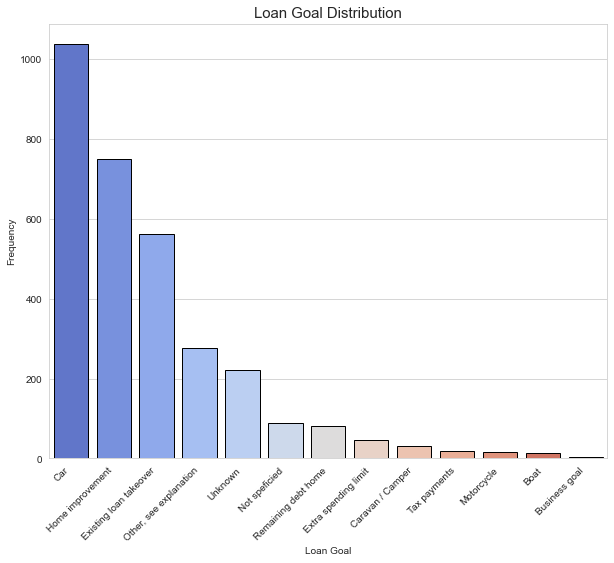

In [204]:
loan_goals_occ = offer_data['LoanGoal'].value_counts()
sns.set_style('whitegrid')
color_palette = sns.color_palette("coolwarm", len(loan_goals_occ))
plt.figure(figsize=[10,8])
ax = sns.barplot(x=loan_goals_occ.index, y=loan_goals_occ, palette=color_palette, edgecolor='black', linewidth=1)
ax.set(xlabel="Loan Goal", ylabel = "Frequency")
ax.set_title("Loan Goal Distribution", fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

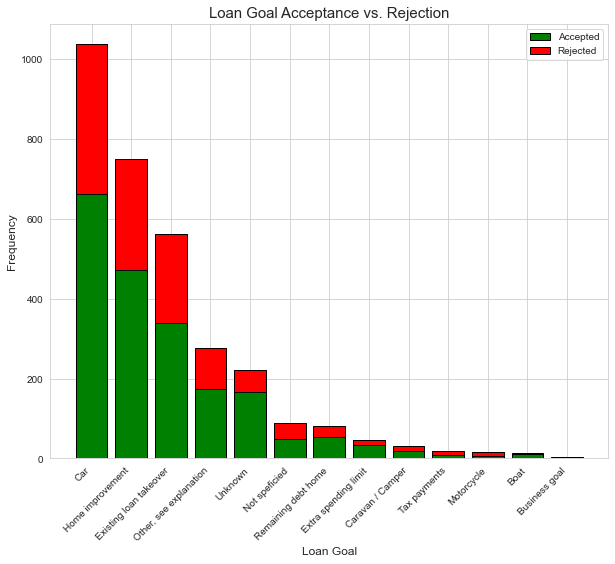

In [205]:
loan_goals_occ = offer_data['LoanGoal'].value_counts()
accepted_goals = offer_data[offer_data['Target'] == True]['LoanGoal'].value_counts()
rejected_goals = offer_data[offer_data['Target'] == False]['LoanGoal'].value_counts()
accepted_goals = accepted_goals.reindex(loan_goals_occ.index, fill_value=0)
rejected_goals = rejected_goals.reindex(loan_goals_occ.index, fill_value=0)
sns.set_style('whitegrid')
plt.figure(figsize=[10,8])
plt.bar(loan_goals_occ.index, accepted_goals, color='g', edgecolor='black', linewidth=1, label='Accepted')
plt.bar(loan_goals_occ.index, rejected_goals, bottom=accepted_goals, color='r', edgecolor='black', linewidth=1, label='Rejected')
plt.xlabel("Loan Goal", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Loan Goal Acceptance vs. Rejection", fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()


In [206]:
data_sorted = data.sort_values(by=['case:concept:name', 'time:timestamp'])
case_duration = data_sorted.groupby('case:concept:name')['time:timestamp'].apply(lambda x: x.max() - x.min())
case_duration
case_duration = case_duration.dt.total_seconds() / 3600  
offer_data_updated = offer_data.copy()
offer_data_updated['case_duration'] = offer_data_updated['CaseID'].map(case_duration)

In [207]:
case_event_counts = data.groupby('case:concept:name').size()

offer_data_updated['TotalEvents'] = offer_data_updated['CaseID'].map(case_event_counts)


In [208]:
offer_data_updated

RequestedAmount  OfferedAmount                  CaseID Target   
9                 20000        20000.0   Application_652823628   True  \
50                10000         6000.0  Application_1691306052  False   
87                15000        15000.0   Application_428409768   True   
145                5000        15700.0  Application_1746793196   True   
208               35000        35000.0   Application_828200680  False   
...                 ...            ...                     ...    ...   
123573            25000        25000.0     Application_4855985   True   
123604             5000         5000.0  Application_1485858591  False   
123634             5000        10000.0  Application_1203711600   True   
123656            15000        15000.0  Application_1199473910   True   
123699             6000         6000.0  Application_1003184938   True   

                      LoanGoal  ReqOfferRatio  case_duration  TotalEvents  
9       Existing loan takeover           1.00     317.965589           40  
50            Home improvement           0.60     147.227285           31  
87            Home improvement           1.00     307.676747           45  
145                        Car           3.14     647.732610           84  
208           Home improvement           1.00     762.004580           21  
...                        ...            ...            ...          ...  
123573  Existing loan takeover           1.00     306.817825           28  
123604        Home improvement           1.00     832.310181           25  
123634        Home improvement           2.00     162.337066           32  
123656                     Car           1.00     168.142317           40  
123699                     Car           1.00     258.606782           38  

[3147 rows x 8 columns]

In [209]:
max_duration_index = offer_data_updated['case_duration'].idxmax()
problematic_offer = offer_data_updated.loc[max_duration_index]
print(problematic_offer)
offer_data_updated = offer_data_updated.drop(max_duration_index)

RequestedAmount                     50000
OfferedAmount                     50000.0
CaseID             Application_2011518740
Target                               True
LoanGoal           Other, see explanation
ReqOfferRatio                         1.0
case_duration                 6865.738515
TotalEvents                            55
Name: 98000, dtype: object


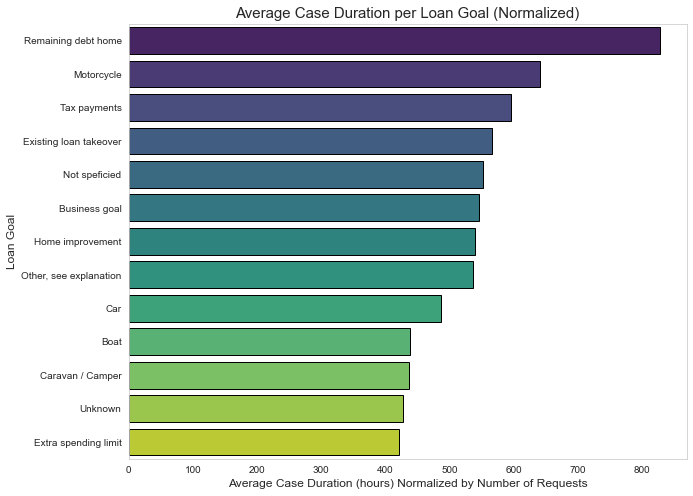

In [210]:
loan_goal_counts = offer_data_updated['LoanGoal'].value_counts()
loan_goal_duration_normalized = offer_data_updated.groupby('LoanGoal')['case_duration'].sum() / loan_goal_counts
loan_goal_duration_normalized = loan_goal_duration_normalized.sort_values(ascending=False)

plt.figure(figsize=[10,8])
sns.barplot(x=loan_goal_duration_normalized.values, y=loan_goal_duration_normalized.index, orient='h', palette='viridis', edgecolor='black')
plt.title('Average Case Duration per Loan Goal (Normalized)', fontsize=15)
plt.xlabel('Average Case Duration (hours) Normalized by Number of Requests', fontsize=12)
plt.ylabel('Loan Goal', fontsize=12)
plt.grid(axis='x')
plt.show()


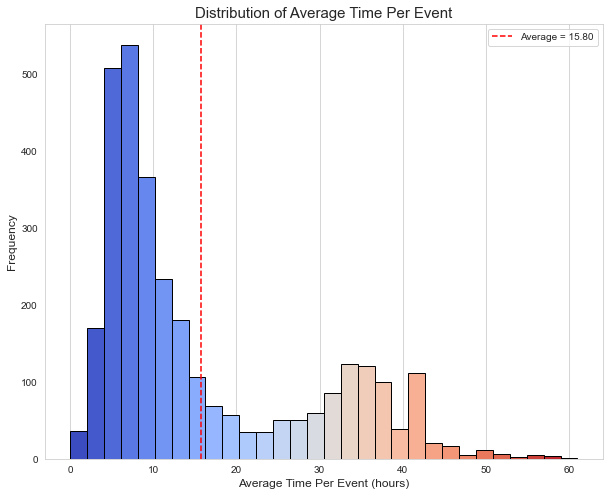

In [211]:
plt.figure(figsize=[10,8])
offer_data_updated['avg_time_per_event'] = offer_data_updated['case_duration'] / offer_data_updated['TotalEvents']

# Add a line that represents the average
avg_time_per_event = offer_data_updated['avg_time_per_event'].mean()
plt.axvline(avg_time_per_event, color='r', linestyle='dashed', linewidth=1.5, label=f"Average = {avg_time_per_event:.2f}")

# Colormap
cmap = plt.get_cmap('coolwarm')
n, bins, patches = plt.hist(offer_data_updated['avg_time_per_event'], bins=30, edgecolor='black')
bin_centers = 0.5 * (bins[:-1] + bins[1:])
col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cmap(c))

plt.title('Distribution of Average Time Per Event', fontsize=15)
plt.xlabel('Average Time Per Event (hours)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y')
plt.legend()  # Show legend for average line

plt.show()


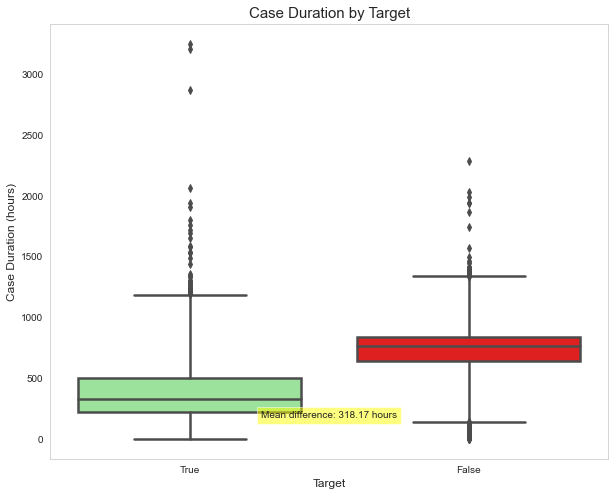

In [212]:
# Convert Target column to string
offer_data_updated['Target'] = offer_data_updated['Target'].astype(str)

plt.figure(figsize=[10,8])
sns.set_style("whitegrid")

# Use custom palette
palette = {"True": "lightgreen", "False": "red"}

# Increase the threshold for outliers (1.5 is the default)
sns.boxplot(x="Target", y="case_duration", data=offer_data_updated, palette=palette, whis=2.5, linewidth=2.5)

plt.title('Case Duration by Target', fontsize=15)
plt.xlabel('Target', fontsize=12)
plt.ylabel('Case Duration (hours)', fontsize=12)

# Calculate the mean difference and add it to the plot
mean_diff = offer_data_updated.groupby("Target")["case_duration"].mean().diff().abs().values[-1]
plt.text(0.5, 0.1, f'Mean difference: {mean_diff:.2f} hours', 
         horizontalalignment='center',
         verticalalignment='center',
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='yellow', alpha=0.5))

plt.grid(axis='y')
plt.show()


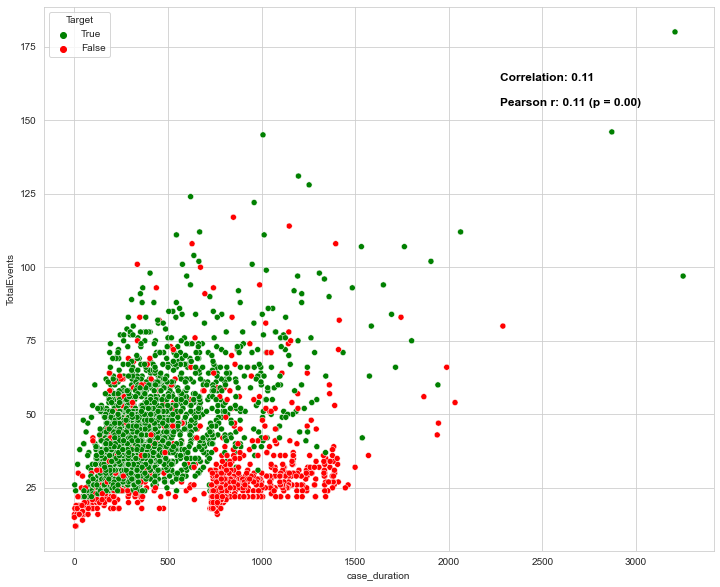

In [216]:
plt.figure(figsize=(12, 10))

# Create scatterplot
scatter_plot = sns.scatterplot(data=offer_data_updated, x="case_duration", y="TotalEvents", hue="Target", palette={"True": "green", "False": "red"})

# Calculate key statistics
avg_case_duration = offer_data_updated["case_duration"].mean()
avg_total_events = offer_data_updated["TotalEvents"].mean()
correlation = offer_data_updated["case_duration"].corr(offer_data_updated["TotalEvents"])
pearsonr = stats.pearsonr(offer_data_updated["case_duration"], offer_data_updated["TotalEvents"])

# Annotate the plot with these statistics
plt.text(offer_data_updated["case_duration"].min() + x_range*0.7, offer_data_updated["TotalEvents"].min() + y_range*0.9, f'Correlation: {correlation:.2f}', fontweight='bold', fontsize=12, color='black')
plt.text(offer_data_updated["case_duration"].min() + x_range*0.7, offer_data_updated["TotalEvents"].min() + y_range*0.85, f'Pearson r: {pearsonr[0]:.2f} (p = {pearsonr[1]:.2f})', fontweight='bold', fontsize=12, color='black')

plt.show()


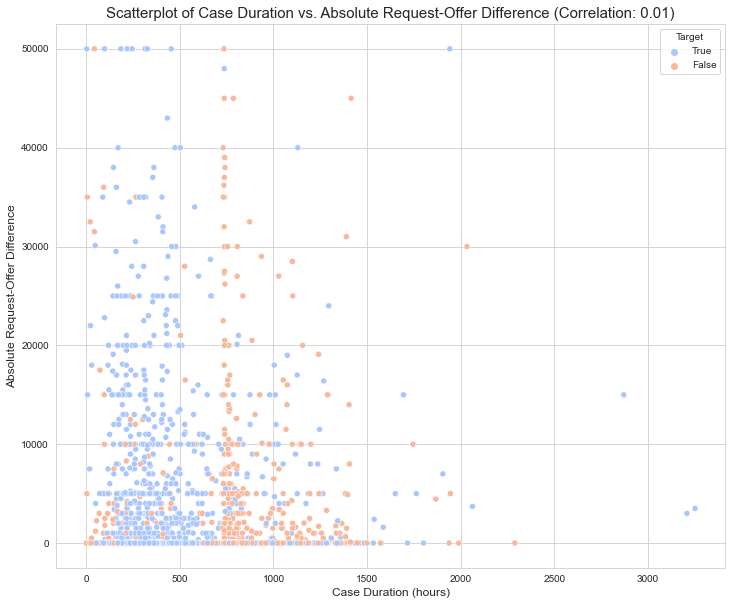

In [214]:
offer_data_updated['AbsReqOfferDiff'] = abs(offer_data_updated['RequestedAmount'] - offer_data_updated['OfferedAmount'])
plt.figure(figsize=(12, 10))
sns.scatterplot(data=offer_data_updated, x='case_duration', y='AbsReqOfferDiff', hue='Target', palette='coolwarm')
correlation = offer_data_updated['case_duration'].corr(offer_data_updated['AbsReqOfferDiff'])
plt.title(f'Scatterplot of Case Duration vs. Absolute Request-Offer Difference (Correlation: {correlation:.2f})', fontsize=15)
plt.xlabel('Case Duration (hours)', fontsize=12)
plt.ylabel('Absolute Request-Offer Difference', fontsize=12)
plt.show()


In [16]:
import pm4py
import pandas as pd
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.visualization.petri_net import visualizer as pn_visualizer


# Read the full dataset log
log = pd.read_csv('./data/BPIChallenge2017.csv')
log['time:timestamp'] = pd.to_datetime(log['time:timestamp'])

# Filter top 50 variants
filtered_log = pm4py.filter_variants_top_k(log, k=50)
print(f"Number of rows after filtering top 50 variants: {len(filtered_log)}")

# Save filtered log as log_50
filtered_log.to_csv('log_50.csv', index=False)



Number of rows after filtering top 50 variants: 168106


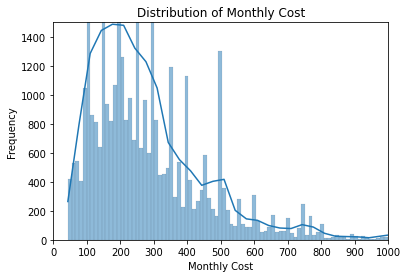

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file into a DataFrame
df = pd.read_csv('./data/BPIattributes.csv')

# Extract the 'MonthlyCost' column from the DataFrame
monthly_cost = df['MonthlyCost']

# Plot the histogram to visualize the distribution
sns.histplot(monthly_cost, kde=True)
plt.xlabel('Monthly Cost')
plt.ylabel('Frequency')
plt.title('Distribution of Monthly Cost')

# Set x-axis and y-axis limits
plt.xlim(0, 1000)
plt.ylim(0, 1500)
num_ticks = 11  # Adjust the number of ticks as desired
plt.xticks(range(0, 1001, 100))

plt.show()


In [124]:
import pandas as pd
df_attributes1 = pd.read_csv('./data/BPIattributes.csv')
df_attributes = df_attributes1[df_attributes1['MonthlyCost'] > 95]
df_attributes.to_csv('./data/BPI2017Loaninfo.csv', index=False)
print((df_attributes.shape[0])/(df_attributes1.shape[0]))



0.951668798697523


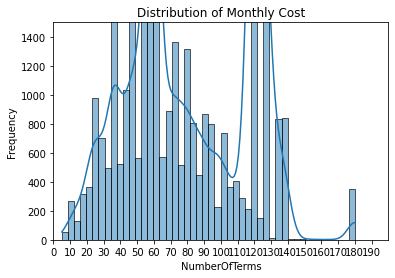

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file into a DataFrame
df = pd.read_csv('./data/BPIattributes.csv')

# Extract the 'MonthlyCost' column from the DataFrame
monthly_cost = df['NumberOfTerms']

# Plot the histogram to visualize the distribution
sns.histplot(monthly_cost, kde=True)
plt.xlabel('NumberOfTerms')
plt.ylabel('Frequency')
plt.title('Distribution of NumberOfTerms')

# Set x-axis and y-axis limits
plt.xlim(0, 200)
plt.ylim(0, 1500)
num_ticks = 15  # Adjust the number of ticks as desired
plt.xticks(range(0, 200,10))

plt.show()


In [125]:
df_attributes1 = pd.read_csv('./data/BPI2017Loaninfo.csv')
df_attributes = df_attributes1[df_attributes1['NumberOfTerms'] > 25]
df_attributes.to_csv('./data/BPI2017Loaninfo.csv', index=False)
df_attributes2 = pd.read_csv('./data/BPIattributes.csv')

print((df_attributes.shape[0])/(df_attributes2.shape[0]))


0.9054541225723921


In [126]:


df_loan_info = pd.read_csv("./data/BPI2017Loaninfo.csv")
df_offer = pd.read_csv('./data/BPIChallenge2017.csv')

# Get the unique loan application names from the loan info file
loan_application_names = df_loan_info['case:concept:name'].unique()

# Filter the offer file to keep only the matching loan applications
df_filtered_offer = df_offer[df_offer['case:concept:name'].isin(loan_application_names)]

# Save the filtered offer file to a new CSV
df_filtered_offer.to_csv('./data/BPI2017Filtered.csv', index=False)

In [127]:
df_2017 = pd.read_csv('./data/BPIChallenge2017.csv')
df_filter = pd.read_csv('./data/BPI2017Filtered.csv')


In [128]:
print(df_2017.shape)
print(df_filter.shape)


(1202267, 20)
(1097447, 20)


In [138]:
import pm4py
import pandas as pd
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.visualization.petri_net import visualizer as pn_visualizer


# Read the full dataset log
log = pd.read_csv('./data/BPI2017Filtered.csv')
log['time:timestamp'] = pd.to_datetime(log['time:timestamp'])

# Filter top 200 variants
filtered_log = pm4py.filter_variants_top_k(log, k=250)
print(f"Number of rows after filtering top 3000 variants: {len(filtered_log)}")


# Save filtered log as log_200
filtered_log.to_csv('./data/log_300.csv', index=False)


Number of rows after filtering top 3000 variants: 270765


In [133]:
df_50 = pd.read_csv('./data/log_50.csv')
df_50 = df_50[~df_50['concept:name'].str.contains('O_Returned')]


In [139]:
df_250 = pd.read_csv('./data/log_250.csv')
df_250 = df_250[~df_250['concept:name'].str.contains('O_Returned')]


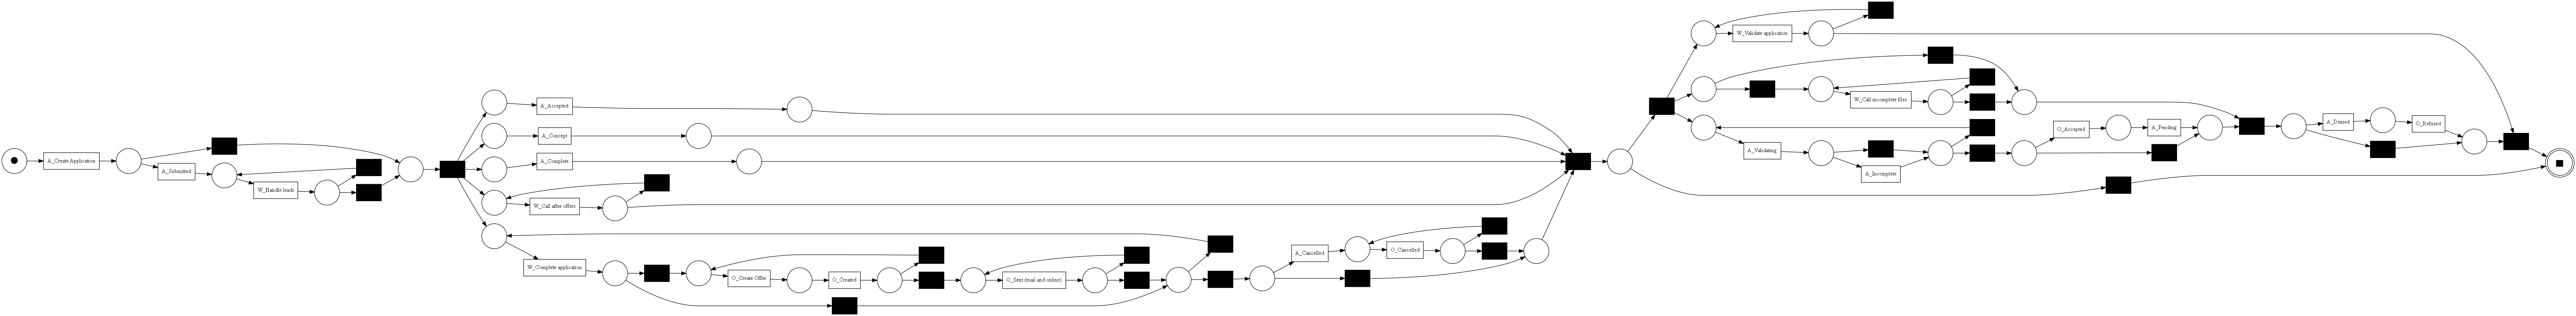

In [23]:
log_50 = log_converter.apply(df_50)
net50I,im50I,fm50I = pm4py.discover_petri_net_inductive(log_50)
pm4py.view_petri_net(net50I, im50I, fm50I)

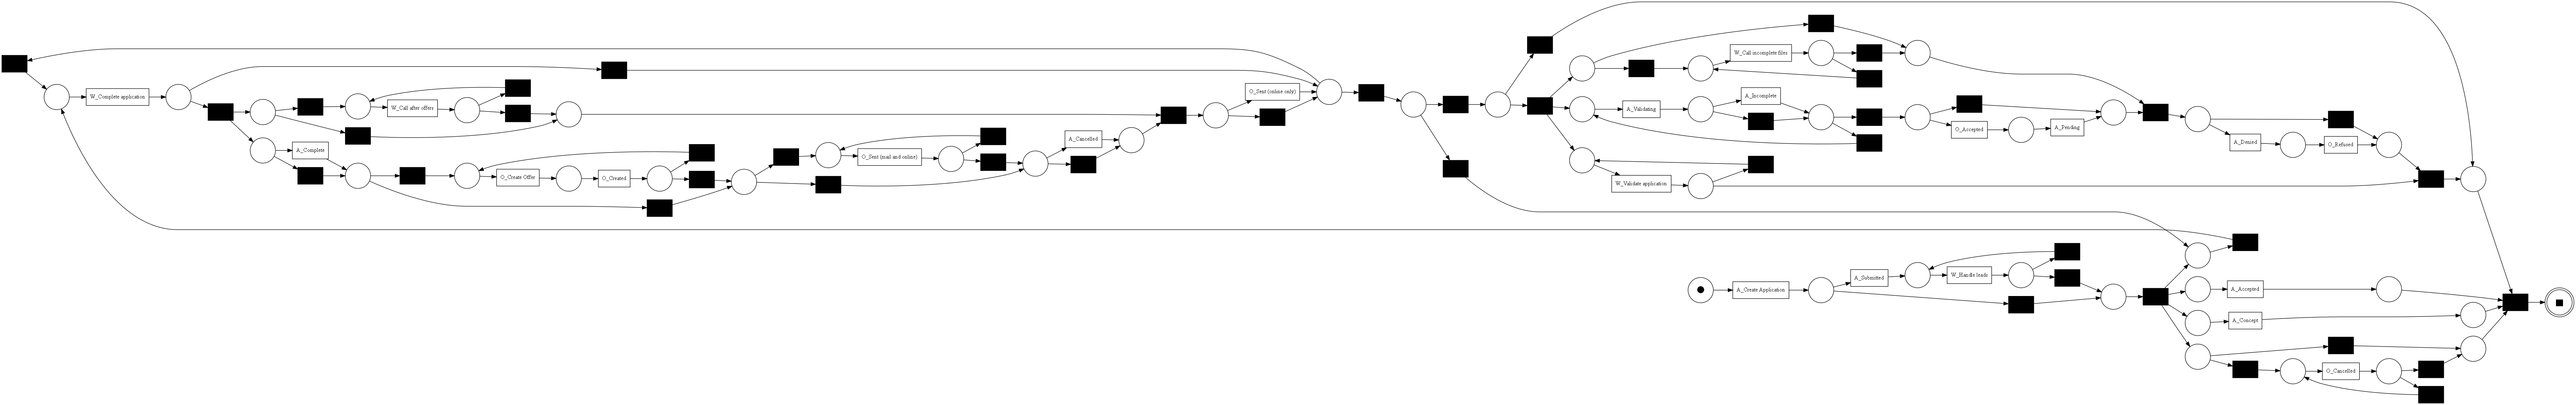

In [140]:
log_250 = log_converter.apply(df_250)
net250I,im250I,fm250I = pm4py.discover_petri_net_inductive(log_250)
pm4py.view_petri_net(net250I, im250I, fm250I)

In [143]:
pm4py.write_pnml(net300I,im300I,fm300I, 'pn1.pnml')

In [146]:
df_2017 = pd.read_csv('./data/BPIChallenge2017.csv')
log_2017 = log_converter.apply(df_2017)
net300I,im300I,fm300I = pm4py.read_pnml('pn1.pnml')
tbr1_fitness = pm4py.fitness_token_based_replay(log_2017, net300I,im300I,fm300I, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')
tbr1_fitness

replaying log with TBR, completed variants ::   9%|██▊                           | 1465/15930 [00:06<01:12, 198.27it/s]


replaying log with TBR, completed variants ::  17%|█████                         | 2703/15930 [00:14<01:16, 172.20it/s]


replaying log with TBR, completed variants ::  23%|██████▉                       | 3715/15930 [00:21<01:43, 118.02it/s]


replaying log with TBR, completed variants ::  29%|████████▊                     | 4694/15930 [00:28<01:25, 131.20it/s]


replaying log with TBR, completed variants ::  36%|██████████▊                   | 5731/15930 [00:35<01:08, 148.04it/s]


replaying log with TBR, completed variants ::  42%|████████████▋                 | 6753/15930 [00:43<01:08, 134.12it/s]


replaying log with TBR, completed variants ::  49%|██████████████▋               | 7823/15930 [00:50<00:56, 142.36it/s]


replaying log with TBR, completed variants ::  55%|█████████████████▏             | 8809/15930 [00:58<01:36, 73.66it/s]


replaying log with TBR, completed variants ::  62%|██████████████████▍           | 9817/15930 [01:05<00:44, 136.97it/s]


replaying log with TBR, completed variants ::  68%|███████████████████▋         | 10824/15930 [01:13<00:42, 120.85it/s]


replaying log with TBR, completed variants ::  74%|█████████████████████▍       | 11808/15930 [01:20<00:29, 140.90it/s]


replaying log with TBR, completed variants ::  81%|███████████████████████▎     | 12825/15930 [01:27<00:21, 142.66it/s]


replaying log with TBR, completed variants ::  87%|█████████████████████████▎   | 13889/15930 [01:34<00:14, 144.64it/s]


replaying log with TBR, completed variants ::  94%|███████████████████████████▎ | 14986/15930 [01:41<00:05, 165.99it/s]


replaying log with TBR, completed variants :: 100%|█████████████████████████████| 15930/15930 [01:47<00:00, 147.90it/s]


{'perc_fit_traces': 86.13412041004158,
 'average_trace_fitness': 0.9977547422404396,
 'log_fitness': 0.9973909777076979,
 'percentage_of_fitting_traces': 86.13412041004158}

In [147]:
tbr1_precision = pm4py.precision_token_based_replay(log_2017, net300I,im300I,fm300I, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')
tbr1_precision


replaying log with TBR, completed variants ::   0%|                              | 848/263907 [00:07<38:06, 115.05it/s]


replaying log with TBR, completed variants ::   1%|▏                            | 1991/263907 [00:14<27:13, 160.38it/s]


replaying log with TBR, completed variants ::   1%|▎                            | 3137/263907 [00:22<22:21, 194.34it/s]


replaying log with TBR, completed variants ::   2%|▍                            | 4249/263907 [00:29<23:32, 183.87it/s]


replaying log with TBR, completed variants ::   2%|▌                            | 5422/263907 [00:37<25:26, 169.29it/s]


replaying log with TBR, completed variants ::   2%|▋                            | 6545/263907 [00:48<33:26, 128.28it/s]


replaying log with TBR, completed variants ::   3%|▊                            | 7686/263907 [00:55<25:37, 166.60it/s]


replaying log with TBR, completed variants ::   3%|▉                            | 8834/263907 [01:03<31:15, 135.99it/s]


replaying log with TBR, completed variants ::   4%|█                           | 10040/263907 [01:10<26:33, 159.29it/s]


replaying log with TBR, completed variants ::   4%|█▏                          | 11211/263907 [01:18<29:28, 142.88it/s]


replaying log with TBR, completed variants ::   5%|█▎                          | 12328/263907 [01:25<26:22, 158.93it/s]


replaying log with TBR, completed variants ::   5%|█▍                          | 13480/263907 [01:33<27:15, 153.13it/s]


replaying log with TBR, completed variants ::   6%|█▌                          | 14684/263907 [01:41<26:53, 154.47it/s]


replaying log with TBR, completed variants ::   6%|█▋                          | 15855/263907 [01:48<22:08, 186.77it/s]


replaying log with TBR, completed variants ::   6%|█▊                          | 16953/263907 [01:56<25:10, 163.44it/s]


replaying log with TBR, completed variants ::   7%|█▉                          | 18161/263907 [02:03<25:40, 159.54it/s]


replaying log with TBR, completed variants ::   7%|██                          | 19497/263907 [02:11<27:48, 146.48it/s]


replaying log with TBR, completed variants ::   8%|██▏                         | 20684/263907 [02:18<28:24, 142.71it/s]


replaying log with TBR, completed variants ::   8%|██▎                         | 21667/263907 [02:26<27:59, 144.24it/s]


replaying log with TBR, completed variants ::   9%|██▍                         | 22639/263907 [02:34<29:09, 137.93it/s]


replaying log with TBR, completed variants ::   9%|██▌                         | 23598/263907 [02:41<28:26, 140.84it/s]


replaying log with TBR, completed variants ::   9%|██▌                         | 24678/263907 [02:49<30:30, 130.72it/s]


replaying log with TBR, completed variants ::  10%|██▋                         | 25732/263907 [02:56<31:26, 126.28it/s]


replaying log with TBR, completed variants ::  10%|██▊                         | 26854/263907 [03:03<28:50, 137.00it/s]


replaying log with TBR, completed variants ::  11%|██▉                         | 27803/263907 [03:11<33:06, 118.87it/s]


replaying log with TBR, completed variants ::  11%|███                         | 28742/263907 [03:18<21:24, 183.07it/s]


replaying log with TBR, completed variants ::  11%|███▎                         | 29677/263907 [03:26<39:22, 99.16it/s]


replaying log with TBR, completed variants ::  12%|███▏                        | 30570/263907 [03:33<31:39, 122.86it/s]


replaying log with TBR, completed variants ::  12%|███▎                        | 31464/263907 [03:41<36:15, 106.85it/s]


replaying log with TBR, completed variants ::  12%|███▍                        | 32475/263907 [03:48<30:22, 126.96it/s]


replaying log with TBR, completed variants ::  13%|███▌                        | 33357/263907 [03:55<31:02, 123.76it/s]


replaying log with TBR, completed variants ::  13%|███▋                        | 34367/263907 [04:02<21:32, 177.53it/s]


replaying log with TBR, completed variants ::  13%|███▊                        | 35368/263907 [04:10<28:58, 131.47it/s]


replaying log with TBR, completed variants ::  14%|███▊                        | 36421/263907 [04:17<29:08, 130.14it/s]


replaying log with TBR, completed variants ::  14%|███▉                        | 37310/263907 [04:25<33:56, 111.25it/s]


replaying log with TBR, completed variants ::  14%|████                        | 38176/263907 [04:32<33:44, 111.51it/s]


replaying log with TBR, completed variants ::  15%|████▏                       | 39210/263907 [04:39<19:26, 192.65it/s]


replaying log with TBR, completed variants ::  15%|████▎                       | 40263/263907 [04:46<35:22, 105.35it/s]


replaying log with TBR, completed variants ::  16%|████▎                       | 41101/263907 [04:54<29:41, 125.04it/s]


replaying log with TBR, completed variants ::  16%|████▍                       | 41995/263907 [05:01<20:23, 181.44it/s]


replaying log with TBR, completed variants ::  16%|████▌                       | 43089/263907 [05:09<36:08, 101.82it/s]


replaying log with TBR, completed variants ::  17%|████▋                       | 44070/263907 [05:16<23:46, 154.13it/s]


replaying log with TBR, completed variants ::  17%|████▊                       | 45037/263907 [05:24<25:14, 144.53it/s]


replaying log with TBR, completed variants ::  17%|████▉                       | 46062/263907 [05:31<19:06, 190.08it/s]


replaying log with TBR, completed variants ::  18%|█████                       | 47495/263907 [05:38<13:48, 261.15it/s]


replaying log with TBR, completed variants ::  18%|█████▏                      | 48541/263907 [05:46<28:35, 125.54it/s]


replaying log with TBR, completed variants ::  19%|█████▎                      | 49583/263907 [05:54<22:28, 158.90it/s]


replaying log with TBR, completed variants ::  19%|█████▍                      | 50921/263907 [06:01<16:43, 212.32it/s]


replaying log with TBR, completed variants ::  20%|█████▌                      | 52248/263907 [06:09<26:42, 132.06it/s]


replaying log with TBR, completed variants ::  20%|█████▋                      | 53240/263907 [06:16<26:32, 132.32it/s]


replaying log with TBR, completed variants ::  21%|█████▊                      | 54293/263907 [06:24<25:08, 138.99it/s]


replaying log with TBR, completed variants ::  21%|█████▉                      | 55757/263907 [06:31<20:22, 170.21it/s]


replaying log with TBR, completed variants ::  22%|██████                      | 56967/263907 [06:39<22:13, 155.15it/s]


replaying log with TBR, completed variants ::  22%|██████▏                     | 58222/263907 [06:46<20:52, 164.17it/s]


replaying log with TBR, completed variants ::  22%|██████▎                     | 59360/263907 [06:53<17:29, 194.89it/s]


replaying log with TBR, completed variants ::  23%|██████▍                     | 60667/263907 [07:01<20:41, 163.67it/s]


replaying log with TBR, completed variants ::  23%|██████▊                      | 61843/263907 [07:09<38:19, 87.89it/s]


replaying log with TBR, completed variants ::  24%|██████▋                     | 62832/263907 [07:16<26:11, 127.91it/s]


replaying log with TBR, completed variants ::  24%|██████▊                     | 63917/263907 [07:24<21:58, 151.73it/s]


replaying log with TBR, completed variants ::  25%|██████▉                     | 65075/263907 [07:31<17:06, 193.65it/s]


replaying log with TBR, completed variants ::  25%|███████                     | 66341/263907 [07:39<27:30, 119.68it/s]


replaying log with TBR, completed variants ::  26%|███████▏                    | 67539/263907 [07:47<26:34, 123.13it/s]


replaying log with TBR, completed variants ::  26%|███████▎                    | 68666/263907 [07:54<20:43, 156.96it/s]


replaying log with TBR, completed variants ::  26%|███████▍                    | 69689/263907 [08:02<23:22, 138.51it/s]


replaying log with TBR, completed variants ::  27%|███████▌                    | 70713/263907 [08:10<25:21, 127.00it/s]


replaying log with TBR, completed variants ::  27%|███████▌                    | 71776/263907 [08:17<27:26, 116.69it/s]


replaying log with TBR, completed variants ::  28%|███████▋                    | 72724/263907 [08:25<30:26, 104.69it/s]


replaying log with TBR, completed variants ::  28%|███████▊                    | 73623/263907 [08:33<23:16, 136.27it/s]


replaying log with TBR, completed variants ::  28%|███████▉                    | 74716/263907 [08:41<21:57, 143.61it/s]


replaying log with TBR, completed variants ::  29%|████████                    | 75684/263907 [08:48<21:53, 143.34it/s]


replaying log with TBR, completed variants ::  29%|████████▍                    | 76675/263907 [08:56<39:54, 78.19it/s]


replaying log with TBR, completed variants ::  29%|████████▏                   | 77697/263907 [09:03<22:06, 140.40it/s]


replaying log with TBR, completed variants ::  30%|████████▎                   | 78738/263907 [09:11<22:29, 137.26it/s]


replaying log with TBR, completed variants ::  30%|████████▍                   | 79737/263907 [09:18<20:43, 148.14it/s]


replaying log with TBR, completed variants ::  31%|████████▌                   | 80751/263907 [09:26<21:40, 140.80it/s]


replaying log with TBR, completed variants ::  31%|████████▋                   | 81815/263907 [09:33<26:08, 116.10it/s]


replaying log with TBR, completed variants ::  31%|████████▊                   | 82986/263907 [09:41<20:13, 149.15it/s]


replaying log with TBR, completed variants ::  32%|████████▉                   | 84127/263907 [09:49<21:54, 136.82it/s]


replaying log with TBR, completed variants ::  32%|█████████                   | 85175/263907 [09:56<23:16, 127.94it/s]


replaying log with TBR, completed variants ::  33%|█████████▏                  | 86148/263907 [10:04<20:00, 148.04it/s]


replaying log with TBR, completed variants ::  33%|█████████▏                  | 87113/263907 [10:11<20:00, 147.29it/s]


replaying log with TBR, completed variants ::  33%|█████████▋                   | 88119/263907 [10:19<29:43, 98.58it/s]


replaying log with TBR, completed variants ::  34%|█████████▍                  | 89028/263907 [10:26<20:08, 144.69it/s]


replaying log with TBR, completed variants ::  34%|█████████▌                  | 90004/263907 [10:34<23:23, 123.90it/s]


replaying log with TBR, completed variants ::  34%|█████████▋                  | 90975/263907 [10:41<21:21, 134.89it/s]


replaying log with TBR, completed variants ::  35%|█████████▊                  | 91966/263907 [10:49<20:10, 142.06it/s]


replaying log with TBR, completed variants ::  35%|█████████▊                  | 92951/263907 [10:57<24:35, 115.86it/s]


replaying log with TBR, completed variants ::  36%|█████████▉                  | 94001/263907 [11:04<16:31, 171.36it/s]


replaying log with TBR, completed variants ::  36%|██████████▍                  | 94893/263907 [11:15<28:10, 99.98it/s]


replaying log with TBR, completed variants ::  36%|██████████▏                 | 95837/263907 [11:22<19:43, 142.04it/s]


replaying log with TBR, completed variants ::  37%|██████████▎                 | 96957/263907 [11:30<16:25, 169.37it/s]


replaying log with TBR, completed variants ::  37%|██████████▍                 | 98034/263907 [11:37<23:16, 118.74it/s]


replaying log with TBR, completed variants ::  37%|██████████▍                 | 98911/263907 [11:45<18:38, 147.55it/s]


replaying log with TBR, completed variants ::  38%|██████████▌                 | 99914/263907 [11:52<24:19, 112.34it/s]


replaying log with TBR, completed variants ::  38%|██████████▎                | 100937/263907 [12:00<17:11, 158.04it/s]


replaying log with TBR, completed variants ::  39%|██████████▍                | 101978/263907 [12:07<19:05, 141.37it/s]


replaying log with TBR, completed variants ::  39%|██████████▌                | 103088/263907 [12:15<15:30, 172.90it/s]


replaying log with TBR, completed variants ::  39%|██████████▋                | 104050/263907 [12:22<19:32, 136.37it/s]


replaying log with TBR, completed variants ::  40%|██████████▋                | 104981/263907 [12:30<20:21, 130.15it/s]


replaying log with TBR, completed variants ::  40%|██████████▊                | 106001/263907 [12:37<21:19, 123.39it/s]


replaying log with TBR, completed variants ::  41%|██████████▉                | 107099/263907 [12:45<21:03, 124.09it/s]


replaying log with TBR, completed variants ::  41%|███████████                | 108250/263907 [12:52<17:43, 146.33it/s]


replaying log with TBR, completed variants ::  41%|███████████▏               | 109276/263907 [13:00<20:12, 127.51it/s]


replaying log with TBR, completed variants ::  42%|███████████▎               | 110429/263907 [13:07<20:11, 126.65it/s]


replaying log with TBR, completed variants ::  42%|███████████▍               | 111574/263907 [13:15<14:44, 172.28it/s]


replaying log with TBR, completed variants ::  43%|███████████▌               | 112829/263907 [13:22<15:11, 165.81it/s]


replaying log with TBR, completed variants ::  43%|███████████▋               | 114041/263907 [13:30<13:49, 180.63it/s]


replaying log with TBR, completed variants ::  44%|███████████▊               | 115309/263907 [13:38<15:36, 158.71it/s]


replaying log with TBR, completed variants ::  44%|███████████▉               | 116369/263907 [13:45<18:36, 132.15it/s]


replaying log with TBR, completed variants ::  44%|████████████               | 117299/263907 [13:53<15:20, 159.32it/s]


replaying log with TBR, completed variants ::  45%|████████████               | 118262/263907 [14:00<16:08, 150.32it/s]


replaying log with TBR, completed variants ::  45%|████████████▏              | 119215/263907 [14:08<20:08, 119.74it/s]


replaying log with TBR, completed variants ::  46%|████████████▎              | 120162/263907 [14:15<15:23, 155.64it/s]


replaying log with TBR, completed variants ::  46%|████████████▍              | 121184/263907 [14:23<20:19, 117.05it/s]


replaying log with TBR, completed variants ::  46%|████████████▍              | 122132/263907 [14:30<17:32, 134.68it/s]


replaying log with TBR, completed variants ::  47%|████████████▌              | 123091/263907 [14:37<19:20, 121.34it/s]


replaying log with TBR, completed variants ::  47%|████████████▋              | 124080/263907 [14:45<21:23, 108.95it/s]


replaying log with TBR, completed variants ::  47%|████████████▊              | 125106/263907 [14:52<16:58, 136.28it/s]


replaying log with TBR, completed variants ::  48%|████████████▉              | 126030/263907 [15:00<20:33, 111.77it/s]


replaying log with TBR, completed variants ::  48%|████████████▉              | 127051/263907 [15:07<17:03, 133.66it/s]


replaying log with TBR, completed variants ::  49%|█████████████              | 128185/263907 [15:15<16:00, 141.25it/s]


replaying log with TBR, completed variants ::  49%|█████████████▏             | 129119/263907 [15:22<19:14, 116.78it/s]


replaying log with TBR, completed variants ::  49%|█████████████▎             | 130021/263907 [15:30<16:16, 137.08it/s]


replaying log with TBR, completed variants ::  50%|█████████████▍             | 131028/263907 [15:37<16:04, 137.77it/s]


replaying log with TBR, completed variants ::  50%|█████████████▌             | 132101/263907 [15:45<17:43, 123.97it/s]


replaying log with TBR, completed variants ::  50%|█████████████▌             | 133035/263907 [15:52<20:48, 104.78it/s]


replaying log with TBR, completed variants ::  51%|█████████████▋             | 134083/263907 [16:00<14:52, 145.44it/s]


replaying log with TBR, completed variants ::  51%|█████████████▊             | 135042/263907 [16:08<21:26, 100.17it/s]


replaying log with TBR, completed variants ::  52%|██████████████▍             | 135937/263907 [16:15<23:31, 90.64it/s]


replaying log with TBR, completed variants ::  52%|██████████████             | 136841/263907 [16:23<19:54, 106.35it/s]


replaying log with TBR, completed variants ::  52%|██████████████             | 137844/263907 [16:30<15:26, 136.06it/s]


replaying log with TBR, completed variants ::  53%|██████████████▏            | 138889/263907 [16:38<13:21, 155.92it/s]


replaying log with TBR, completed variants ::  53%|██████████████▎            | 139982/263907 [16:45<14:05, 146.51it/s]


replaying log with TBR, completed variants ::  53%|██████████████▍            | 141111/263907 [16:52<18:34, 110.13it/s]


replaying log with TBR, completed variants ::  54%|███████████████             | 141992/263907 [17:00<20:38, 98.45it/s]


replaying log with TBR, completed variants ::  54%|██████████████▌            | 142911/263907 [17:07<18:00, 111.94it/s]


replaying log with TBR, completed variants ::  54%|██████████████▋            | 143813/263907 [17:15<15:11, 131.69it/s]


replaying log with TBR, completed variants ::  55%|██████████████▊            | 144734/263907 [17:22<18:25, 107.83it/s]


replaying log with TBR, completed variants ::  55%|██████████████▉            | 145595/263907 [17:29<14:39, 134.56it/s]


replaying log with TBR, completed variants ::  56%|███████████████            | 146648/263907 [17:37<14:32, 134.41it/s]


replaying log with TBR, completed variants ::  56%|███████████████            | 147731/263907 [17:44<11:04, 174.89it/s]


replaying log with TBR, completed variants ::  56%|███████████████▏           | 148837/263907 [17:52<13:08, 145.99it/s]


replaying log with TBR, completed variants ::  57%|███████████████▎           | 149817/263907 [18:00<12:47, 148.65it/s]


replaying log with TBR, completed variants ::  57%|███████████████▍           | 150954/263907 [18:07<15:59, 117.67it/s]


replaying log with TBR, completed variants ::  58%|███████████████▌           | 152076/263907 [18:14<11:18, 164.90it/s]


replaying log with TBR, completed variants ::  58%|███████████████▋           | 153215/263907 [18:22<09:57, 185.36it/s]


replaying log with TBR, completed variants ::  58%|███████████████▊           | 154301/263907 [18:29<14:01, 130.29it/s]


replaying log with TBR, completed variants ::  59%|███████████████▊           | 155166/263907 [18:37<13:23, 135.41it/s]


replaying log with TBR, completed variants ::  59%|███████████████▉           | 156045/263907 [18:44<17:55, 100.28it/s]


replaying log with TBR, completed variants ::  59%|████████████████           | 157010/263907 [18:51<13:42, 129.92it/s]


replaying log with TBR, completed variants ::  60%|████████████████▏          | 157989/263907 [18:59<11:39, 151.33it/s]


replaying log with TBR, completed variants ::  60%|████████████████▎          | 158884/263907 [19:06<14:17, 122.50it/s]


replaying log with TBR, completed variants ::  61%|████████████████▎          | 159872/263907 [19:14<10:08, 170.84it/s]


replaying log with TBR, completed variants ::  61%|████████████████▍          | 160991/263907 [19:21<09:23, 182.62it/s]


replaying log with TBR, completed variants ::  61%|████████████████▌          | 162097/263907 [19:29<09:37, 176.35it/s]


replaying log with TBR, completed variants ::  62%|████████████████▋          | 163211/263907 [19:36<11:51, 141.61it/s]


replaying log with TBR, completed variants ::  62%|████████████████▊          | 164151/263907 [19:44<16:00, 103.85it/s]


replaying log with TBR, completed variants ::  63%|████████████████▉          | 165243/263907 [19:51<12:23, 132.76it/s]


replaying log with TBR, completed variants ::  63%|█████████████████          | 166357/263907 [19:59<09:25, 172.47it/s]


replaying log with TBR, completed variants ::  63%|█████████████████▏         | 167483/263907 [20:06<09:04, 177.05it/s]


replaying log with TBR, completed variants ::  64%|█████████████████▉          | 168491/263907 [20:14<16:18, 97.50it/s]


replaying log with TBR, completed variants ::  64%|█████████████████▎         | 169483/263907 [20:21<11:10, 140.91it/s]


replaying log with TBR, completed variants ::  65%|██████████████████          | 170353/263907 [20:29<21:29, 72.56it/s]


replaying log with TBR, completed variants ::  65%|█████████████████▌         | 171220/263907 [20:36<11:54, 129.66it/s]


replaying log with TBR, completed variants ::  65%|█████████████████▌         | 172056/263907 [20:44<13:08, 116.55it/s]


replaying log with TBR, completed variants ::  66%|█████████████████▋         | 173011/263907 [20:51<10:02, 150.76it/s]


replaying log with TBR, completed variants ::  66%|█████████████████▊         | 173915/263907 [20:59<12:32, 119.60it/s]


replaying log with TBR, completed variants ::  66%|█████████████████▉         | 174779/263907 [21:06<12:58, 114.49it/s]


replaying log with TBR, completed variants ::  67%|█████████████████▉         | 175593/263907 [21:13<09:10, 160.49it/s]


replaying log with TBR, completed variants ::  67%|██████████████████         | 176533/263907 [21:21<14:05, 103.37it/s]


replaying log with TBR, completed variants ::  67%|██████████████████▏        | 177371/263907 [21:28<13:14, 108.98it/s]


replaying log with TBR, completed variants ::  68%|██████████████████▏        | 178352/263907 [21:35<09:06, 156.56it/s]


replaying log with TBR, completed variants ::  68%|███████████████████         | 179297/263907 [21:43<14:41, 95.99it/s]


replaying log with TBR, completed variants ::  68%|██████████████████▍        | 180376/263907 [21:51<13:31, 102.96it/s]


replaying log with TBR, completed variants ::  69%|██████████████████▌        | 181183/263907 [21:59<12:29, 110.33it/s]


replaying log with TBR, completed variants ::  69%|██████████████████▋        | 182207/263907 [22:06<11:29, 118.42it/s]


replaying log with TBR, completed variants ::  69%|██████████████████▋        | 183149/263907 [22:14<10:49, 124.37it/s]


replaying log with TBR, completed variants ::  70%|██████████████████▊        | 184103/263907 [22:21<06:59, 190.11it/s]


replaying log with TBR, completed variants ::  70%|██████████████████▉        | 185079/263907 [22:29<11:26, 114.91it/s]


replaying log with TBR, completed variants ::  71%|███████████████████        | 186208/263907 [22:36<07:39, 169.22it/s]


replaying log with TBR, completed variants ::  71%|███████████████████▏       | 187143/263907 [22:44<10:49, 118.25it/s]


replaying log with TBR, completed variants ::  71%|███████████████████▏       | 188060/263907 [22:51<09:37, 131.27it/s]


replaying log with TBR, completed variants ::  72%|███████████████████▎       | 189119/263907 [22:59<08:16, 150.51it/s]


replaying log with TBR, completed variants ::  72%|███████████████████▍       | 190174/263907 [23:06<08:07, 151.10it/s]


replaying log with TBR, completed variants ::  72%|███████████████████▌       | 191191/263907 [23:14<08:57, 135.25it/s]


replaying log with TBR, completed variants ::  73%|███████████████████▋       | 192176/263907 [23:21<08:48, 135.63it/s]


replaying log with TBR, completed variants ::  73%|███████████████████▊       | 193243/263907 [23:29<09:04, 129.83it/s]


replaying log with TBR, completed variants ::  74%|███████████████████▊       | 194229/263907 [23:36<07:43, 150.25it/s]


replaying log with TBR, completed variants ::  74%|███████████████████▉       | 195296/263907 [23:44<08:38, 132.21it/s]


replaying log with TBR, completed variants ::  74%|████████████████████       | 196386/263907 [23:51<09:11, 122.48it/s]


replaying log with TBR, completed variants ::  75%|████████████████████▏      | 197314/263907 [23:59<07:21, 150.70it/s]


replaying log with TBR, completed variants ::  75%|█████████████████████       | 198251/263907 [24:07<17:45, 61.61it/s]


replaying log with TBR, completed variants ::  75%|████████████████████▎      | 199104/263907 [24:14<10:05, 106.94it/s]


replaying log with TBR, completed variants ::  76%|█████████████████████▏      | 199910/263907 [24:22<13:09, 81.10it/s]


replaying log with TBR, completed variants ::  76%|████████████████████▌      | 200734/263907 [24:29<08:22, 125.61it/s]


replaying log with TBR, completed variants ::  76%|████████████████████▌      | 201407/263907 [25:08<10:07, 102.90it/s]


replaying log with TBR, completed variants ::  77%|████████████████████▋      | 202287/263907 [25:16<08:24, 122.23it/s]


replaying log with TBR, completed variants ::  77%|████████████████████▊      | 203207/263907 [25:23<07:36, 132.88it/s]


replaying log with TBR, completed variants ::  77%|█████████████████████▋      | 203984/263907 [25:30<10:06, 98.85it/s]


replaying log with TBR, completed variants ::  78%|████████████████████▉      | 204717/263907 [25:38<09:42, 101.60it/s]


replaying log with TBR, completed variants ::  78%|█████████████████████      | 205691/263907 [25:45<08:28, 114.55it/s]


replaying log with TBR, completed variants ::  78%|█████████████████████▉      | 206479/263907 [25:52<17:59, 53.18it/s]


replaying log with TBR, completed variants ::  79%|█████████████████████▏     | 207361/263907 [26:00<08:00, 117.77it/s]


replaying log with TBR, completed variants ::  79%|█████████████████████▎     | 208230/263907 [26:07<07:00, 132.36it/s]


replaying log with TBR, completed variants ::  79%|█████████████████████▍     | 209103/263907 [26:14<07:30, 121.68it/s]


replaying log with TBR, completed variants ::  80%|█████████████████████▍     | 210098/263907 [26:22<04:26, 201.88it/s]


replaying log with TBR, completed variants ::  80%|█████████████████████▌     | 210919/263907 [26:30<07:32, 117.16it/s]


replaying log with TBR, completed variants ::  80%|█████████████████████▋     | 211842/263907 [26:37<04:51, 178.48it/s]


replaying log with TBR, completed variants ::  81%|█████████████████████▊     | 212911/263907 [26:45<07:06, 119.52it/s]


replaying log with TBR, completed variants ::  81%|██████████████████████▋     | 213727/263907 [26:52<08:22, 99.96it/s]


replaying log with TBR, completed variants ::  81%|█████████████████████▉     | 214844/263907 [27:00<05:01, 162.71it/s]


replaying log with TBR, completed variants ::  82%|██████████████████████     | 215926/263907 [27:07<03:48, 209.97it/s]


replaying log with TBR, completed variants ::  82%|██████████████████████▏    | 216940/263907 [27:15<06:01, 129.91it/s]


replaying log with TBR, completed variants ::  83%|██████████████████████▎    | 217758/263907 [27:22<06:26, 119.33it/s]


replaying log with TBR, completed variants ::  83%|██████████████████████▎    | 218626/263907 [27:29<06:03, 124.71it/s]


replaying log with TBR, completed variants ::  83%|██████████████████████▍    | 219595/263907 [27:37<03:52, 190.41it/s]


replaying log with TBR, completed variants ::  84%|██████████████████████▌    | 220553/263907 [27:44<05:44, 125.98it/s]


replaying log with TBR, completed variants ::  84%|██████████████████████▋    | 221600/263907 [27:52<04:46, 147.73it/s]


replaying log with TBR, completed variants ::  84%|███████████████████████▌    | 222614/263907 [27:59<06:54, 99.54it/s]


replaying log with TBR, completed variants ::  85%|██████████████████████▉    | 223716/263907 [28:07<03:39, 183.21it/s]


replaying log with TBR, completed variants ::  85%|██████████████████████▉    | 224789/263907 [28:14<04:45, 136.78it/s]


replaying log with TBR, completed variants ::  86%|███████████████████████    | 225700/263907 [28:22<04:42, 135.12it/s]


replaying log with TBR, completed variants ::  86%|███████████████████████▏   | 226650/263907 [28:29<05:13, 118.90it/s]


replaying log with TBR, completed variants ::  86%|███████████████████████▎   | 227491/263907 [28:37<04:51, 125.11it/s]


replaying log with TBR, completed variants ::  87%|███████████████████████▎   | 228331/263907 [28:45<05:16, 112.35it/s]


replaying log with TBR, completed variants ::  87%|███████████████████████▍   | 229196/263907 [28:52<04:56, 117.18it/s]


replaying log with TBR, completed variants ::  87%|███████████████████████▌   | 230054/263907 [28:59<03:35, 156.73it/s]


replaying log with TBR, completed variants ::  88%|███████████████████████▋   | 230930/263907 [29:07<05:02, 109.19it/s]


replaying log with TBR, completed variants ::  88%|███████████████████████▋   | 231926/263907 [29:14<03:54, 136.11it/s]


replaying log with TBR, completed variants ::  88%|███████████████████████▊   | 232888/263907 [29:22<04:16, 120.73it/s]


replaying log with TBR, completed variants ::  89%|███████████████████████▉   | 234002/263907 [29:29<03:18, 150.93it/s]


replaying log with TBR, completed variants ::  89%|████████████████████████   | 235094/263907 [29:37<03:42, 129.72it/s]


replaying log with TBR, completed variants ::  89%|████████████████████████▏  | 236029/263907 [29:44<03:33, 130.57it/s]


replaying log with TBR, completed variants ::  90%|████████████████████████▎  | 237139/263907 [29:52<02:43, 163.36it/s]


replaying log with TBR, completed variants ::  90%|████████████████████████▎  | 238115/263907 [30:00<03:47, 113.49it/s]


replaying log with TBR, completed variants ::  91%|████████████████████████▍  | 239025/263907 [30:08<03:47, 109.57it/s]


replaying log with TBR, completed variants ::  91%|████████████████████████▌  | 239941/263907 [30:15<02:38, 151.63it/s]


replaying log with TBR, completed variants ::  91%|████████████████████████▋  | 240925/263907 [30:22<03:48, 100.51it/s]


replaying log with TBR, completed variants ::  92%|████████████████████████▋  | 241831/263907 [30:30<02:46, 132.48it/s]


replaying log with TBR, completed variants ::  92%|████████████████████████▊  | 242704/263907 [30:37<03:20, 105.49it/s]


replaying log with TBR, completed variants ::  92%|████████████████████████▉  | 243733/263907 [30:45<02:50, 118.33it/s]


replaying log with TBR, completed variants ::  93%|█████████████████████████  | 244566/263907 [30:52<02:30, 128.26it/s]


replaying log with TBR, completed variants ::  93%|█████████████████████████  | 245575/263907 [31:00<02:42, 112.60it/s]


replaying log with TBR, completed variants ::  93%|█████████████████████████▏ | 246454/263907 [31:07<02:54, 100.22it/s]


replaying log with TBR, completed variants ::  94%|█████████████████████████▎ | 247422/263907 [31:15<01:59, 138.32it/s]


replaying log with TBR, completed variants ::  94%|█████████████████████████▍ | 248499/263907 [31:22<02:01, 126.95it/s]


replaying log with TBR, completed variants ::  95%|█████████████████████████▌ | 249396/263907 [31:30<01:54, 126.75it/s]


replaying log with TBR, completed variants ::  95%|█████████████████████████▌ | 250391/263907 [31:37<01:14, 180.86it/s]


replaying log with TBR, completed variants ::  95%|█████████████████████████▋ | 251510/263907 [31:45<01:33, 132.63it/s]


replaying log with TBR, completed variants ::  96%|█████████████████████████▊ | 252471/263907 [31:52<01:28, 129.72it/s]


replaying log with TBR, completed variants ::  96%|██████████████████████████▊ | 253236/263907 [32:00<01:54, 92.86it/s]


replaying log with TBR, completed variants ::  96%|█████████████████████████▉ | 254109/263907 [32:07<01:11, 136.55it/s]


replaying log with TBR, completed variants ::  97%|██████████████████████████ | 255056/263907 [32:15<01:18, 113.47it/s]


replaying log with TBR, completed variants ::  97%|██████████████████████████▏| 255968/263907 [32:22<00:54, 145.30it/s]


replaying log with TBR, completed variants ::  97%|██████████████████████████▎| 256992/263907 [32:30<00:51, 135.00it/s]


replaying log with TBR, completed variants ::  98%|██████████████████████████▍| 257994/263907 [32:37<00:41, 143.35it/s]


replaying log with TBR, completed variants ::  98%|██████████████████████████▍| 258909/263907 [32:45<00:43, 116.12it/s]


replaying log with TBR, completed variants ::  98%|███████████████████████████▌| 259726/263907 [32:53<00:43, 95.59it/s]


replaying log with TBR, completed variants ::  99%|██████████████████████████▋| 260504/263907 [33:00<00:30, 111.54it/s]


replaying log with TBR, completed variants ::  99%|██████████████████████████▋| 261327/263907 [33:08<00:25, 102.96it/s]


replaying log with TBR, completed variants ::  99%|██████████████████████████▊| 262128/263907 [33:15<00:15, 115.41it/s]


replaying log with TBR, completed variants :: 100%|██████████████████████████▉| 263031/263907 [33:23<00:05, 148.28it/s]


replaying log with TBR, completed variants :: 100%|███████████████████████████| 263907/263907 [33:33<00:00, 131.04it/s]


0.23609360132349988